# Web Scraping Monster.com for In-Demand Data Science Skills

I came across [this nice blog post](https://jessesw.com/Data-Science-Skills/) by Jesse Steinweg-Woods about how to scrape [Indeed.com](https://www.indeed.com) for key skills that employers are looking for in data scientists. Jesse showed the graphic below by [Swami Chandrasekaran](http://nirvacana.com/thoughts/becoming-a-data-scientist/) to demonstrate the point that it would take a lifetime (or more) to master all the tools required to qualify for every job listing.

<img src="./assets/RoadToDataScientist1.png" alt="data scientist roadmap" style="width: 50em;"/>

Rather than learn everything, we should learn the tools that have the greatest probability of ending up on the "requirements" list of a job posting. We can go to a website like Indeed and collect the keywords commonly used in data science postings. Then we can plot the keyword versus its frequency, as a function of the city in which one would like to work. 

Jesse developed some nice code in Python to:
* Construct a URL to the search results for job postings matching a given city and state (or nationwide, if none are specified)
* Extract and tally keywords from data science job postings listed in the search results

Below were the results for NYC back in 2015, when he wrote this code (credit to Jesse for the graphic).

<img src="./assets/proj6_nb_22_1.png" alt="data scientist top keywords nyc" style="width: 35em;"/>

---

I decided to apply a similar analysis to [Monster.com](https://www.monster.com/), another job listings board. I am curious as to how similar the results are to Indeed. Of course, it's been four years since Jesse's original analysis, so there more variables in play than the change in platform.

## URL Formatting

The URL format for data science jobs in NYC is quite simple. For the first page of results:

`https://www.monster.com/jobs/search/?q=data-scientist&where=New-York__2C-NY`

And part of the results are shown below:

<img src="./assets/screenshot.png" alt="data scientist top keywords nyc" style="width: 35em;"/>

One must click the "Load more jobs" button to load more results onto the page. When clicking the button for the first time, the link displayed in the browser barchanges in the following way:

`...New-York__2C-NY&stpage=1&page=2`

These query parameters set the starting page and ending page of the results displayed. So if the final `&page` argument is set to 3, there will be three pages of results. If one chooses a page too far ahead, an "Error 404" page is returned.

From trial and error, I found that setting `page=10` yields all the relevant results in a single page. The `Load more jobs` button no longer appears once you get to 10 pages. This typically yields about 250 search results, even though it says "1335 Jobs Found" on the page. We will work with whatever results come up on the first 10 pages.
 
## Search Results and Job Descriptions

We will use the `requests` package to retrieve the HTML and `BeautifulSoup` to parse it.

In [1]:
import requests
from bs4 import BeautifulSoup

first_url = 'https://www.monster.com/jobs/search/?q=data-scientist&where=New-York__2C-NY'

response = requests.get(first_url)
soup = BeautifulSoup(response.text, 'html.parser')

In the HTML, there are sections with the data attribute `data-jobid`, which correspond to the IDs of the job listings. These are also used in constructing the URL to access the listing page. We can write a function that grabs the IDs.

In [2]:
all_listings = soup.find_all('section', attrs={'data-jobid': True})
ids = [item['data-jobid'] for item in all_listings]

We can also obtain the job title, company name, and city/state combo from the HTML:

In [3]:
loc_strings = list()
for x in all_listings:
    loc_string = x.find('div', attrs={'class': 'location'}).find('span', attrs={'class': 'name'}).text.strip()
    
    if ',' in loc_string:
        city, state = [a.strip() for a in loc_string.split(',')]
        state = state[:2]  # two-letter state format
        loc_strings.append(', '.join([city, state]))
    else:
        loc_strings.append('')
    
companies = [x.find('div', attrs={'class': 'company'}).find('span', attrs={'class': 'name'}).text.strip()
             for x in all_listings]

job_titles = [x.find('h2', attrs={'class': 'title'}).find('a', href=True).string.strip() for x in all_listings]

print(job_titles[0])
print(companies[0])
print(loc_strings[0])

Senior Data Scientist - Corporate Training & Passion Projects!
CyberCoders
New York City, NY


### No Need for Web Browser Automation...

If we click on the job listings directly from the links on the left-hand sidebar, the descriptions are loaded **dynamically** into the right-hand column, which means that the DOM is modified via JavaScript. But `requests` only loads the unmodified page source, so it will not pick up on these changes. We could use [Selenium](https://www.seleniumhq.org/), which allows one to automate a web browser and parse the DOM as it changes. The returned HTML would reflect what we see after the job listing fields have been populated. To reduce overhead, one could use a [**headless**](https://intoli.com/blog/running-selenium-with-headless-chrome/) version of Chrome, which allows us to use the browser in the background without loading any browser windows.

But we would like to avoid this if it is not absolutely necessary, as one must spend extra time waiting for page elements to load. It can also be quite resource-intensive. Luckily, we do not need to do this. Within the page source, each result comes with another URL that leads to a static job description page:

In [4]:
new_urls = [x.find('h2', attrs={'class': 'title'}).find('a', href=True)['href'] for x in all_listings]
new_urls[0]

'https://job-openings.monster.com/senior-data-scientist-corporate-training-passion-projects-new-york-city-ny-us-cybercoders/208243552'

So we can extract the description from this URL:

In [5]:
job_url = new_urls[0]
response = requests.get(job_url)
soup = BeautifulSoup(response.text, 'html.parser')

In [6]:
job_body = soup.find('div', attrs={'id': 'JobDescription'})

desc = job_body.get_text(separator=' ')  # add whitespace between HTML tags

print(desc[:1000] + '...')


 Location: Work remote, though you must live near a major airport.  Up to 25% travel.  Skills: 3+ years industry data science, strong Python We are a Data Science education company with customers across the globe.  We offer training to corporations from start ups to Fortune 500s and everything in between. We are passionate about Data Science and sharing skills through education and are looking for a Data Scientist who feels the same! Top Reasons to Work with Us - Work with like minded people who are super passionate about data science and education - This role provides a unique mix of teaching, business projects and passion projects - We are a startup company owned by a global giant so you get the best of both worlds - that startup vibe but with security. - Competitive annual salary and full benefits. - You should ideally live in the SF bay or New York, however you can work REMOTE! (With 25% travel). What You Will Be Doing As our Corporate Senior Data Scientist your role will be as fo

We don't care how organized the paragraphs are. We just want to count the relevant keywords in this block of text.

## Keyword Parsing

<img src="./assets/wework_application.png" alt="data scientist top keywords nyc" style="width: 35em;"/>

By the time you see this tutorial, the sample job description is likely to have changed. I will load the first result that popped up when I did my search - a job posting for a senior data scientist at WeWork:

In [7]:
with open('./data/wework_description.txt', 'r') as f:
    job_desc = f.read()
    
print(job_desc[:1000] + '...')

WeWork is the platform for creators, providing hundreds of thousands of members across the globe space, community, and services that enable them to do what they love and craft their life's work. Our mission is to build a world where people work to make a life, not just a living, and our own team members are central to that goal.  WeWork is looking for creative, technically minded Data Scientists who are motivated to solve some of the world’s most challenging problems. Data is at the heart of our business at WeWork and as a Data Scientist, you will leverage this resource to evaluate and provide insights into both our physical, and digital products & features. In collaboration with a multidisciplinary team of engineers and analysts, you will apply diligent statistical methods, robust code, and transparent scientific rigor to creatively develop models that will be embedded in software products that deliver data-driven insights seamlessly to end users where they need it, and when they need

Now we would like to come up with a list of terms we can scan the text for. I went with the same keywords used by Jesse in his blog post:

In [8]:
from helpers import DATA_SCI_KEYWORDS

print(DATA_SCI_KEYWORDS)

['R', 'Python', 'Java', 'C++', 'Ruby', 'Perl', 'Matlab', 'JavaScript', 'Scala', 'Excel', 'Tableau', 'D3.js', 'SAS', 'SPSS', 'D3', 'Hadoop', 'MapReduce', 'Spark', 'Pig', 'Hive', 'Shark', 'Oozie', 'ZooKeeper', 'Flume', 'Mahout', 'SQL', 'NoSQL', 'HBase', 'Cassandra', 'MongoDB']


We will create a `Counter` from the `collections` library and tally the occurrences of each of these keywords within the text. But first, we need to break the description down into a list of words. Below is a sample of code, partially lifted from Jesse's post, that does so:

In [9]:
import re
from nltk.corpus import stopwords

delete_matching = "[^a-zA-Z.+3]"  # this saves letters, dots, and the number 3 (the last two are for D3.js)

lines = (line.strip() for line in job_desc.splitlines())

# break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))

# Get rid of all blank lines and ends of line
text = ''.join(chunk + ' ' for chunk in chunks if chunk).encode('utf-8')

# Now clean out all of the unicode junk
text = text.decode('unicode_escape')

# Get rid of any terms that aren't words
text = re.sub(delete_matching, " ", text)

text = text.lower().split()  # Go to lower case and split them apart

stop_words = set(stopwords.words("english"))

words = list()
keywords_lower = [x.lower() for x in DATA_SCI_KEYWORDS]
for w in text:
    if w not in keywords_lower:
        w = w.replace('.', '')
    if w not in stop_words and len(w) > 0:
        words.append(w)

# Just get the set of these.
all_words = list(set(words))

Now, how many of these words are in our list of keywords? Let's get the frequencies for all keywords that appear at least once.

In [10]:
from collections import Counter
import pandas as pd

freqs = Counter(all_words)

out_dict = dict([(x, freqs[x.lower()]) for x in DATA_SCI_KEYWORDS])
df = pd.DataFrame.from_dict(out_dict, orient='index', columns=['Frequency']).reset_index()
df = df.rename(columns={'index': 'Keyword'}).sort_values(by='Frequency', ascending=False).reset_index(drop=True)
df.loc[df['Frequency'] > 0]

,Keyword,Frequency
0,R,1
1,Matlab,1
2,Python,1
3,SAS,1
4,SQL,1
5,C++,1
6,Java,1


For a list of search results, we will do the same thing, while increasing the count of each term everytime it appears in a listing.

## Full Implementation + Results

I ended up taking an object-oriented approach to this problem. I created classes that represented different components of the process:

* `MonsterLocation`, which contains a city/state combination along with an optional tuple of alternate nearby cities/states that are considered "equal" to this location in the search results.
* `MonsterListing`, representing an individual listing returned from the search. Each listing contains a job ID, the company, the `MonsterLocation` (without 
* `MonsterSearch`, which contains the search parameters, along with a dictionary of returned `MonsterLocation` objects indexed by their unique ID

This approach allows us to construct search queries and grab information from listings in a succinct way.


### Fetching a single listing

Below we grab a single listing from Brooklyn using the ID and print the info, plus a snippet of the description.

In [11]:
from monster import MonsterListing, MonsterLocation

city = "New York"
state = "NY"
alternates = ("Brooklyn, NY",)  # "Brooklyn, NY" is near "New York, NY", so include it as an alternate
location = MonsterLocation(city, state, alternates=alternates)

# We will pick a listing from Brooklyn, NY
job_id = '208183191'

listing = MonsterListing.from_id(job_id)  # get listing details from search page (excluding description)
listing.fetch_description()  # get description from static webpage; separate step

# "Brooklyn, NY" is considered equal to "New York, NY" because we listed it as 
# an alternate (nearby) city
print(listing.__str__() + '\n')
print(listing.get_excerpt() + '\n')
print(location == listing.location)

Job Title: Business Development Manager
Company: Jobot
Location: Brooklyn, NY
ID: 208183191


 Fast growing biotech startup looking for a Business Development Manager Read Below and See If This Position Is A Fit! If so, Easy Apply now by clicking the "Apply" button and sending us your resume. If you are a fit, our Jobot Pro, Alec Pedersen, will get back to you with more details! Market Development Manager - Fast Growing Biotechnology startup A bit about us:   Based in Brooklyn, NY we are a well-funded, fast growing Biotechnology startup using Data Science & Artificial Intelligence to revolutionize the healthcare industry! Our next generation data capture tools give medical professionals the information they need to treat patients with increased efficiency, precision, and at lower costs. We turned the corner on becoming profitable last year and need to scale our business development team. If you are a Business Development Professional with Healthcare/Biotech/Pharmaceutical Industry expe

### Fetching search results

Let's load the first page of search results. We'll search for listings on the term "Data Scientist", and we'll allow any listings that include this in the title - along with "Data Science" or "Data Engineer". We won't load the descriptions, because this takes a long time; we need to individually load each static listing page and extract the description.

In [12]:
from monster import MonsterSearch

query = "Data Scientist"
page_limit = 1
alternates = ("Brooklyn, NY", "Jersey City, NJ", "Hoboken, NJ", "Secaucus, NJ", "Newark, NJ", "Manhattan, NY",
              "New York City, NY")
location = MonsterLocation.from_string("New York, NY", alternates=alternates)
extra_titles = ("Data Science", "Data Engineer")  # extra possible phrases in title, other than "Data Scientist"

# create search and fetch first page
search = MonsterSearch(location, query, extra_titles=extra_titles)
search.fetch_listings(limit=page_limit)  # get all listings (without descriptions...)

# get first listing + description (job ids stored in order they were retrieved)
listing = search.results[search.job_ids[0]]
listing.fetch_description()

print(listing.__str__() + '\n')
print(listing.get_excerpt() + '\n')

Job Title: Senior Data Scientist - Corporate Training & Passion Projects!
Company: CyberCoders
Location: New York City, NY
ID: 208243552


 Location: Work remote, though you must live near a major airport.  Up to 25% travel.  Skills: 3+ years industry data science, strong Python We are a Data Science education company with customers across the globe.  We offer training to corporations from start ups to Fortune 500s and everything in between. We are passionate about Data Science and sharing skills through education and are looking for a Data Scientist who feels the same! Top Reasons to Work with Us - Work with like minded people who are super passionate about data science and education - This role provides a unique mix of teaching, business projects and passion projects - We are a startup company owned by a global giant so you get the best of both worlds - that startup vibe but with security. - Competitive annual salary and full benefits. - You should ideally live in the SF bay or New Y

### Counts for a search: NYC Data Scientist jobs

Below we'll load the results from a previous search for data scientist positions in NYC, with the intention of getting the counts for the keywords in `DATA_SCI_KEYWORDS`. I conducted this search on May 19th, 2019, and I obtained all of the descriptions.

In [13]:
import json

filename = './data/data_scientist_nyc_search.json'

with open(filename, 'r') as f:
    search = MonsterSearch.json_deserialize(in_dict=json.load(f))
    
print(search)

Search Query: Data Scientist
Location: New York, NY
Number of Listings: 179


Let's get the counts for all the keywords in `DATA_SCI_KEYWORDS` within the 179 listings.

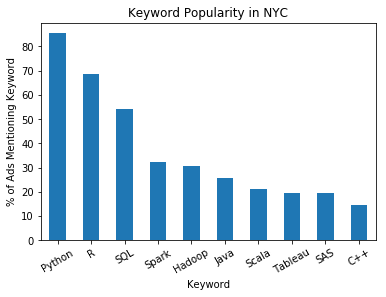

In [14]:
from monster import MonsterTextParser
import matplotlib.pyplot as plt
%matplotlib inline

filename = './data/data_scientist_nyc_search.json'

with open(filename, 'r') as f:
    search = MonsterSearch.json_deserialize(in_dict=json.load(f))

# get individual keyword counts as percentage of ads mentioning the keyword
tally = MonsterTextParser(DATA_SCI_KEYWORDS).count_words(search, as_percentage=True)

top_10 = tally.iloc[:10]

fig, ax = plt.subplots(1, 1)
top_10.plot.bar(x='Keyword', rot=30, ax=ax, legend=False)
ax.set_ylabel('% of Ads Mentioning Keyword')
ax.set_title('Keyword Popularity in NYC');

So we can see here that Python, R, and SQL are the holy triumvirate of the data scientist's toolkit - as expected! These were also the top three languages in NYC when Jesse scraped Indeed back in 2015, but R took the top spot back then. Jesse also had more search results (300, versus the 179 I'm using here), so it's possible the distribution would change if I acquired more data. But it's good to know that the results aren't too far off from what is expected!